# Детекция игральных карт

Сыграем в карты?

В этом задании попробуем написать практически с нуля архитектуру для детекции, а в конце воспользоваться готовым решением YOLOv11.

Датасет с игральными картами от девятки до туза (6 классов). Мы научимся искать и выделять на фотографиях несколько типов карт. Датасет содержит около 300 картинок, данные хранятся в xml в формате PascalVOC.

## Данные

Скачаем датасет и начнем работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2025-02-08 23:06:46--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2025-02-08 23:06:47--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M   213MB/s    in 0.2s    

2025-02-08 23:06:48 (213 MB/s) - ‘data.zip’ saved [38392108/38392108]



## Подготовка датасета

Напишем код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # Извлекаем координаты bounding box'а
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)

        # Извлекаем название класса и преобразуем его в int
        class_name = member.find("name").text
        class_id = class_dict[class_name]

        # Добавляем bounding box и класс в список
        bboxes.append([xmin, ymin, xmax, ymax, class_id])

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):

        fname = self.filenames[idx]

        image = np.array(Image.open(fname).convert("RGB"))

        # Получаем bounding box'ы и классы
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        # Применяем трансформации
        transformed = self.transform(image=image, bboxes=bboxes)
        image = transformed["image"]
        bboxes = transformed["bboxes"]

        return image, bboxes

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

## Визуализация данных

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишем функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит нам сделать обратное преобразование: int, содержащий класс, в строку с названием.

In [ ]:
import matplotlib.patches as patches
def visualize(images, bboxes, class_dict_inv):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)  # Отключаем оси

        if i >= len(images):
            break  # Если изображений меньше, чем подграфиков, пропускаем лишние

        # Откат нормализации и перестановка каналов
        image = images[i].permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
        image = image * std + mean  # Откат нормализации
        image = image.clip(0, 1)  # Обрезаем значения до диапазона [0, 1]
        ax.imshow(image)

        # Рисуем bounding box'ы и подписываем классы
        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, class_id = bbox
            class_name = class_dict_inv[class_id]  # Преобразуем id класса в название

            # Рисуем прямоугольник
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2,
                edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

            # Добавляем текст с названием класса
            ax.text(
                xmin, ymin - 5, class_name, color='white',
                bbox=dict(facecolor='red', alpha=0.7, edgecolor='none')
            )

    # Убираем пустые подграфики, если количество изображений нечетное
    for j in range(len(images), len(axes)):
        axes[j].axis('off')

    fig.tight_layout()
    plt.show()

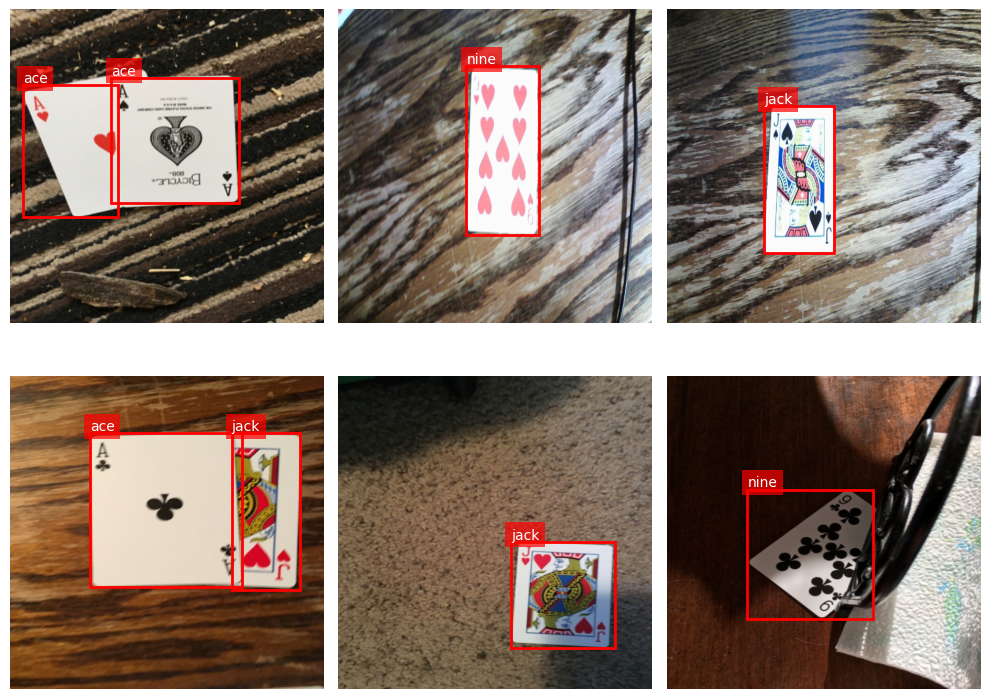

In [ ]:
# Получаем несколько примеров из датасета
out = [train_ds[i] for i in range(6)]

# Разделяем изображения и bounding box'ы
images = [o[0] for o in out]
bboxes = [o[1] for o in out]

visualize(images, bboxes, train_ds.class_dict_inv)

## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Создание батча

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b[0], b[1]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуем ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  xmax - xmin # размер клетки по X в пикс
        y_cell =  ymax - ymin # размер клетки по Y в пикс
        w_box =  x_cell / w # ширина бокса отнормированная
        h_box =  y_cell / h # высота бокса отнормированная

        # Посчитаем координаты центра и сдвиги
        cx =  (xmin + xmax) / 2 # (координаты центра в исходных координатах)
        cy =  (ymin + ymax) / 2
        cx_idx = (cx / w * (w // downsample)).long() # (посчитаем индекс центра на карте признаков размера 16x16,
         # это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = (cy / h * (h // downsample)).long() #

        cx_box = cx / downsample + cx_idx # посчитаем сдивиги относительно cx_idx)
        cy_box = cy / downsample + cy_idx

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

In [ ]:
# Получаем несколько примеров из датасета
out = [train_ds[i] for i in range(4)]

# Вызываем функцию collate_fn
batch = collate_fn(out)

print("Images shape:", batch["image"].shape)  # Должно быть BxCxHxW
print("Target shape:", batch["target"].shape)  # Должно быть Bx6x16x16

Images shape: torch.Size([4, 3, 512, 512])
Target shape: torch.Size([4, 6, 16, 16])


Ниже можно увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

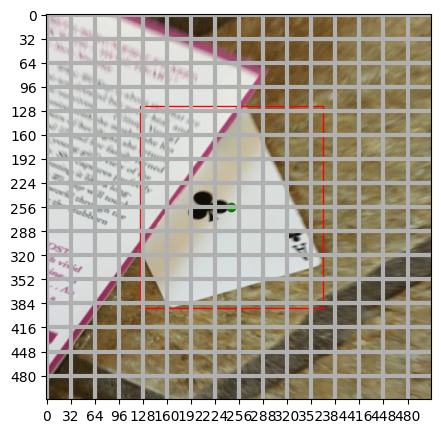

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i][0].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i][1])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Декодирование предсказаний

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. В задаче классификации target является одним числом, но выход сетки содержит длинный вектор, из которого мы получаем вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуем обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function мы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

В target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    h, w = int(h), int(w)
    img_w, img_h = w * upsample, h * upsample
    results = []

    for i in range(b):
        boxes = []

        for y in range(h):
            for x in range(w):
                cell_pred = pred[i, :, y, x]

                if c == 6:
                    cx_box, cy_box, w_box, h_box, conf, cls = cell_pred
                    cls = int(cls)
                else:
                    cx_box, cy_box, w_box, h_box, conf = cell_pred[:5]
                    cls_probs = cell_pred[5:]
                    cls = torch.argmax(cls_probs).item()

                if conf.item() < threshold:
                    continue

                cx = (x + cx_box.item()) * upsample
                cy = (y + cy_box.item()) * upsample

                w_box_abs = w_box.item() * img_w
                h_box_abs = h_box.item() * img_h

                # Преобразуем координаты центра в координаты углов
                xmin = cx - w_box_abs / 2
                ymin = cy - h_box_abs / 2
                xmax = cx + w_box_abs / 2
                ymax = cy + h_box_abs / 2

                boxes.append([xmin, ymin, xmax, ymax, cls])

        results.append(boxes)

    return results

## Реализация модели
Реализуем модель. Первым делом применим первые 4 блока (до layer4 включительно) ResNet50. Далее добавим несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшим количество каналов до 5+C, а размер изображения до 16 на 16. Получим 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в нашем датасете (6). Размер ядра при этом 3, паддинг 1. **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

In [ ]:
C =  len(train_ds.class_dict)


class Detector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
        )
        self.additional_layers = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.final_conv = nn.Conv2d(32, 5+num_classes, kernel_size=3, padding=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        features = self.feature_extractor(img)

        features = self.additional_layers(features)

        output = self.sigmoid(self.final_conv(features))

        return output

In [ ]:
num_classes = len(train_ds.class_dict)

model = Detector(num_classes=num_classes)

# Пример входного тензора (батч из 2 изображений размера 3x512x512)
input_tensor = torch.randn(2, 3, 512, 512)

output = model(input_tensor)

print("Output shape:", output.shape)  # Ожидаемый результат: (2, 5+C, 16, 16)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.2MB/s]


Output shape: torch.Size([2, 11, 16, 16])


## Функция потерь

Реализуем функцию потерь.

Для этого:
* Сделаем маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select.
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)

In [ ]:
def special_loss(pred, target, check=False, C=3):
    # Создаем маску для детектируемых объектов
    object_mask = target[:, 4, :, :] > 0  # Confidence > 0 означает наличие объекта
    no_object_mask = ~object_mask         # Отрицание маски для пикселей без объектов

    # Localization loss (MSE по координатам центра bbox)
    localization_loss = nn.MSELoss(reduction='sum')(
        torch.masked_select(pred[:, :2, :, :], object_mask.unsqueeze(1)),
        torch.masked_select(target[:, :2, :, :], object_mask.unsqueeze(1))
    )

    # Box loss (MSE по корням ширины и высоты bbox)
    pred_wh = torch.sqrt(torch.sqrt(pred[:, 2:4, :, :]))  # Корни предсказанных w, h
    target_wh = torch.sqrt(torch.sqrt(target[:, 2:4, :, :]))  # Корни целевых w, h
    box_loss = nn.MSELoss(reduction='sum')(
        torch.masked_select(pred_wh, object_mask.unsqueeze(1)),
        torch.masked_select(target_wh, object_mask.unsqueeze(1))
    )

    # Classification loss (кросс-энтропия для классов)
    classification_loss = nn.CrossEntropyLoss(reduction='sum')(
        torch.permute(pred[:, 5:, :, :], (0, 2, 3, 1))[object_mask],  # Предсказания классов
        target[:, 5, :, :][object_mask].long()  # Целевые классы
    )

    # Confidence loss (бинарная кросс-энтропия для confidence)
    confidence_loss_obj = nn.BCELoss(reduction='sum')(
        torch.masked_select(pred[:, 4, :, :], object_mask),
        torch.masked_select(target[:, 4, :, :], object_mask)
    )
    confidence_loss_noobj = nn.BCELoss(reduction='sum')(
        torch.masked_select(pred[:, 4, :, :], no_object_mask),
        torch.masked_select(target[:, 4, :, :], no_object_mask)
    )
    confidence_loss = confidence_loss_obj + 0.1 * confidence_loss_noobj  # Вес 0.1 для noobj

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss
    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [ ]:
# Пример входных данных
pred = torch.zeros((10, 8, 16, 16))  # Bx(5+C)xHxW
target = torch.ones((10, 8, 16, 16))  # Bx(5+C)xHxW
target[:, 4, :, :] = (target[:, 4, :, :] > 0.5).float()  # Confidence: 0 или 1

# Вычисляем лосс
loss = special_loss(pred, target, check=True, C=3)
print("Localization loss:", loss[0].item())
print("Box loss:", loss[1].item())
print("Classification loss:", loss[2].item())
print("Confidence loss:", loss[3].item())

# Полный лосс
total_loss = special_loss(pred, target, check=False, C=3)
print("Total loss:", total_loss.item())

Localization loss: 5120.0
Box loss: 5120.0
Classification loss: 2812.446533203125
Confidence loss: 256000.0
Total loss: 269052.4375


In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

## Обучение модели

Обучим нашу модель (написав цикл обучения), и покажем что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  15
model = Detector(num_classes=len(train_ds.class_dict)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:

        images = batch["image"].to(device)
        targets = batch["target"].to(device)

        opt.zero_grad()

        predictions = model(images)

        loss = special_loss(predictions, targets, check=False, C=len(train_ds.class_dict))


        loss.backward()

        opt.step()

        epoch_losses.append(loss.item())

        pbar.set_description(f"Loss {loss.item():.3f}")


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 9178.535;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 9063.333;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 9043.742;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 9037.903;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 9036.586;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 9034.996;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 9032.521;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 9032.366;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 9032.587;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 9032.696;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 9031.655;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 9030.179;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 9029.878;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 9029.468;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 9029.671;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu

images = batch["image"].to(device)

model.eval()

with torch.no_grad():
  predictions = model(images)

predictions = predictions.cpu()

decoded_boxes = decode_prediction(predictions, upsample=32, threshold=0.8)

In [ ]:
def visualize_predictions(images, predictions, class_dict_inv, upsample=32):

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    # Создаем сетку для отображения изображений
    fig, axes = plt.subplots(2, len(images) // 2 + len(images) % 2, figsize=(15, 10))
    axes = axes.reshape(-1)  # Преобразуем axes в одномерный массив

    for i, ax in enumerate(axes):
        ax.axis(False)  # Отключаем оси

        if i >= len(images):
            break  # Если изображений меньше, чем подграфиков, пропускаем лишние

        # Откат нормализации и перестановка каналов
        image = images[i].permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
        image = image * std + mean  # Откат нормализации
        image = image.clip(0, 1)  # Обрезаем значения до диапазона [0, 1]

        # Отображаем изображение
        ax.imshow(image)

        # Рисуем bounding box'ы и подписываем классы
        for bbox in predictions[i]:
            xmin, ymin, xmax, ymax, class_id = bbox
            class_name = class_dict_inv[class_id]  # Преобразуем id класса в название

            # Рисуем прямоугольник
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2,
                edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

            # Добавляем текст с названием класса
            ax.text(
                xmin, ymin - 5, class_name, color='white',
                bbox=dict(facecolor='red', alpha=0.7, edgecolor='none')
            )

    # Убираем пустые подграфики, если количество изображений нечетное
    for j in range(len(images), len(axes)):
        axes[j].axis('off')

    fig.tight_layout()
    plt.show()

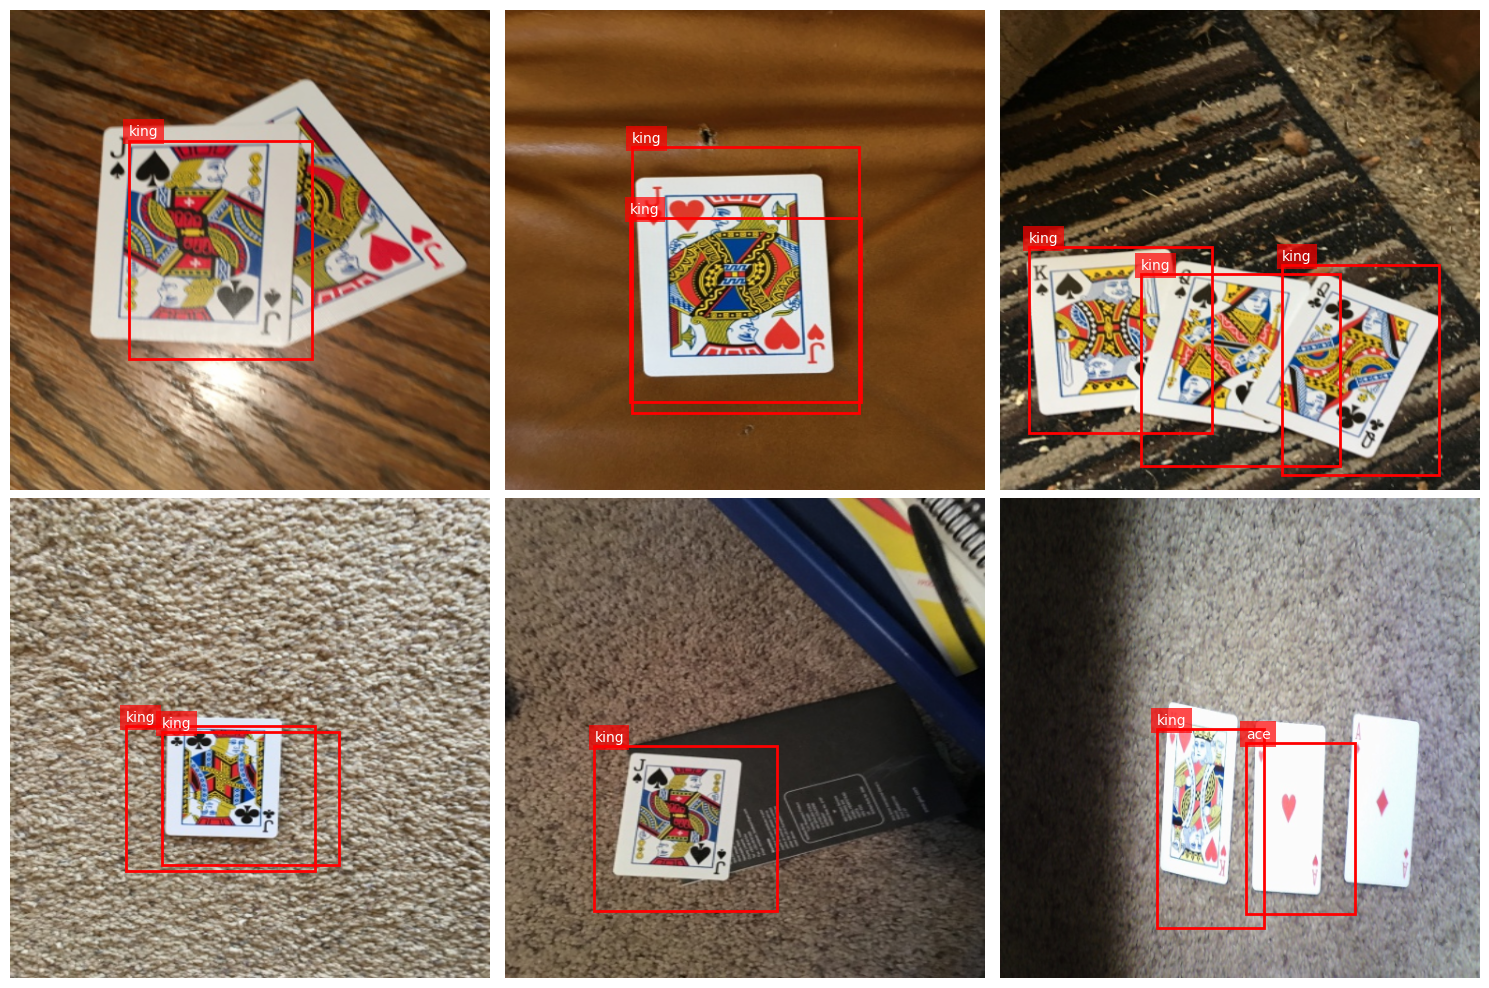

In [ ]:
# Визуализируем результаты с помощью visualize_predictions
visualize_predictions(
    images.cpu(), decoded_boxes, class_dict_inv=train_ds.class_dict_inv
)

Результат сильно так себе. Всё таки конструировать YOLO самому сложно. Попробуем готовое решение

## YOLOv11 от ultralytics

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v11 от ultralytics.

In [ ]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 781.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00


## Подготовка данных для YOLO

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid, в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуем функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    result = []

    for bbox in bboxes:
      xmin, ymin, xmax, ymax, class_id = bbox

      cx = (xmin + xmax) / 2
      cy = (ymin + ymax) / 2

      width = xmax - xmin
      height = ymax - ymin

      cx_norm = cx / w_im
      cy_norm = cy / h_im

      width_norm = width / w_im
      height_norm = height / h_im

      yolo_line = f"{int(class_id)} {cx_norm:.6f} {cy_norm:.6f} {width_norm:.6f} {height_norm:.6f}"
      result.append(yolo_line)

    return result

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc = len(train_ds.class_dict) # число классов
names = list(train_ds.class_dict.keys()) # имена классов

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Обучение YOLO

Обучим модель YOLO v11 самого маленького размера. Библиотека максимально friendly, от нас требуется написать две строчки. Модель возьмем необученную.


In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

model.train(data="data.yaml", epochs=100, imgsz=640, device=device)

engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fals

train: Scanning /content/train/labels.cache... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.13G     0.6353      3.354      1.054         34        640: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         37         61    0.00116      0.128     0.0402     0.0387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.96G     0.5773       2.78     0.9806         28        640: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         37         61     0.0015      0.126    0.00655     0.0054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.96G     0.6533      2.238      1.016         45        640: 100%|██████████| 21/21 [00:06<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         37         61      0.545     0.0303     0.0155     0.0153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.95G     0.6502      1.886      1.004         22        640: 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         37         61      0.745     0.0541     0.0453     0.0449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.95G     0.6227      1.744     0.9976         34        640: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         37         61     0.0713     0.0877     0.0185     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.96G     0.5943      1.647     0.9808         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]

                   all         37         61     0.0555     0.0877      0.017     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.95G     0.6021      1.582     0.9969         26        640: 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         37         61      0.483     0.0541     0.0462     0.0428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.95G     0.6061       1.48     0.9998         15        640: 100%|██████████| 21/21 [00:10<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         37         61     0.0966     0.0779     0.0338     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.93G     0.5661       1.36     0.9524         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         37         61      0.104     0.0779      0.052     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.96G     0.6051      1.291      0.982         19        640: 100%|██████████| 21/21 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         37         61      0.135     0.0779     0.0502      0.048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.95G     0.5799      1.216     0.9607         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         37         61     0.0851     0.0779     0.0642     0.0579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.96G     0.5579      1.129     0.9504         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         37         61      0.278     0.0779     0.0458     0.0407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.95G     0.5506      1.082     0.9557         19        640: 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         37         61      0.133     0.0779     0.0563     0.0544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.96G     0.5432      1.054     0.9464         25        640: 100%|██████████| 21/21 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         37         61      0.399     0.0877     0.0804     0.0796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.96G     0.5406      1.082     0.9476         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         37         61      0.147     0.0877     0.0645     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.95G     0.5316      1.025     0.9446         28        640: 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         37         61      0.375     0.0779     0.0641     0.0636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.95G     0.5053     0.9363     0.9296         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         37         61       0.13     0.0779     0.0466     0.0436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.96G     0.5113     0.9317     0.9328         26        640: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         37         61      0.142     0.0785     0.0272     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.95G     0.4875     0.8864     0.9237         21        640: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         37         61     0.0906     0.0779     0.0334     0.0307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.95G     0.5008     0.8732     0.9319         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         37         61     0.0917     0.0779     0.0218     0.0206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.95G     0.5072     0.8501     0.9282         34        640: 100%|██████████| 21/21 [00:08<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         37         61      0.103     0.0779     0.0516     0.0514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.96G     0.5056     0.8436     0.9238         26        640: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         37         61      0.189     0.0779     0.0677     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.95G     0.4876     0.7871     0.9278         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         37         61      0.109     0.0779     0.0516      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.95G     0.4878     0.7618     0.9232         22        640: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         37         61      0.121     0.0779     0.0555     0.0507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.95G     0.5344     0.7783      0.942         24        640: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         37         61       0.11     0.0779     0.0583     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.96G     0.4683      0.726     0.9114         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         37         61      0.104     0.0779       0.04     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.96G     0.4827     0.7077     0.9232         18        640: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         37         61     0.0974     0.0779     0.0401     0.0398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.95G     0.4543     0.6752     0.9083         33        640: 100%|██████████| 21/21 [00:06<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


                   all         37         61       0.13     0.0779     0.0681     0.0674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.95G     0.4799     0.6693     0.9198         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         37         61      0.173     0.0779     0.0598     0.0594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.96G     0.4812     0.6867     0.9207         31        640: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         37         61      0.258     0.0779     0.0601     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.93G     0.4693     0.6862     0.9208         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


                   all         37         61      0.275     0.0779     0.0541     0.0532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.95G     0.4658     0.6811     0.9167         18        640: 100%|██████████| 21/21 [00:07<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         37         61     0.0933     0.0779     0.0339     0.0331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.96G     0.4581     0.6744     0.9056         18        640: 100%|██████████| 21/21 [00:09<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         37         61      0.124     0.0779     0.0814     0.0802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.96G     0.4799     0.6432     0.9207         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

                   all         37         61     0.0955     0.0782     0.0257     0.0239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.95G     0.4601     0.6464     0.9163         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         37         61     0.0982     0.0779     0.0232     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.96G     0.4711     0.6391     0.9154         18        640: 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         37         61     0.0836     0.0779     0.0577     0.0558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.95G     0.4505     0.5908     0.9026         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         37         61     0.0828     0.0779     0.0313     0.0298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.94G     0.4535     0.5933     0.9265         17        640: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         37         61     0.0866     0.0779      0.035      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.95G     0.4565     0.5624     0.9081         26        640: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         37         61     0.0912     0.0779     0.0304     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.96G     0.4564     0.5743     0.9021         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         37         61      0.103     0.0779     0.0229     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.96G     0.4386     0.5595     0.9046         17        640: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         37         61      0.103     0.0779      0.034     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.96G     0.4441     0.5577     0.9084         20        640: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         37         61      0.105     0.0779     0.0681     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.95G     0.4579     0.5782     0.9194         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]

                   all         37         61      0.087     0.0779     0.0384      0.038



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.95G     0.4391     0.5485     0.9061         31        640: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         37         61     0.0854     0.0779     0.0418     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.95G     0.4388     0.5179     0.8944         23        640: 100%|██████████| 21/21 [00:06<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         37         61     0.0951     0.0779      0.046     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.96G      0.426     0.5309     0.8949         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         37         61      0.112     0.0779     0.0584      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.95G     0.4235     0.5251     0.9013         10        640: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         37         61     0.0826     0.0779      0.052     0.0505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.95G     0.4106     0.5075     0.8918         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         37         61     0.0988     0.0779     0.0283     0.0264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.95G     0.4386     0.5319     0.8986         25        640: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         37         61      0.106     0.0779     0.0605     0.0594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.97G     0.4151     0.4977     0.8903         35        640: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


                   all         37         61     0.0915     0.0779     0.0481     0.0478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.95G     0.4165     0.4929     0.8887         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         37         61      0.103     0.0779     0.0533     0.0524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.95G     0.4004     0.4763      0.893         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         37         61     0.0988     0.0877     0.0545     0.0537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.96G     0.3916      0.478     0.8855         23        640: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         37         61     0.0992     0.0876     0.0633     0.0624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.96G      0.404     0.4863     0.8825         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         37         61      0.112     0.0779     0.0595     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.93G     0.3922     0.4855     0.8801         13        640: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         37         61      0.104     0.0779     0.0373     0.0359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.98G     0.3953     0.4602     0.8864         19        640: 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

                   all         37         61      0.101     0.0779     0.0514     0.0491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.95G     0.4066     0.4777     0.8946         23        640: 100%|██████████| 21/21 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         37         61     0.0911     0.0779      0.023     0.0216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.97G      0.393     0.4653      0.874         30        640: 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         37         61     0.0886     0.0779     0.0322     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.95G     0.4014     0.4598     0.8925         24        640: 100%|██████████| 21/21 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         37         61     0.0862     0.0779     0.0276     0.0258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.95G     0.3744     0.4582      0.889         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         37         61      0.086     0.0779     0.0458     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.95G     0.3753     0.4598     0.8858         29        640: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         37         61     0.0842     0.0779     0.0237     0.0204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.96G     0.3923      0.451     0.8794         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         37         61     0.0943     0.0779     0.0455     0.0437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.95G     0.4072     0.4638     0.8957         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         37         61      0.144     0.0779      0.074      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.95G     0.3677     0.4311     0.8659         25        640: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         37         61     0.0843     0.0779     0.0431     0.0428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.95G     0.3924     0.4515     0.8842         34        640: 100%|██████████| 21/21 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         37         61     0.0859     0.0779     0.0507     0.0503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.96G     0.3844     0.4373     0.8814         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         37         61     0.0869     0.0779     0.0555      0.055



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.95G     0.3981     0.4512     0.8957         17        640: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         37         61     0.0974     0.0779     0.0596     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.95G     0.3932     0.4356     0.8849         29        640: 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         37         61      0.104     0.0779     0.0557     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.95G     0.3783     0.4078     0.8806         18        640: 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         37         61     0.0893     0.0779     0.0482     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.96G     0.3765     0.4077     0.8745         33        640: 100%|██████████| 21/21 [00:09<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         37         61     0.0864     0.0779     0.0357     0.0352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.95G     0.3713     0.4184      0.874         35        640: 100%|██████████| 21/21 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         37         61     0.0833     0.0779     0.0538     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.95G     0.3767     0.4145     0.8741         26        640: 100%|██████████| 21/21 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         37         61     0.0863     0.0779     0.0626     0.0616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.95G     0.3718     0.3869     0.8796         21        640: 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         37         61     0.0904     0.0779      0.058     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.96G     0.3616     0.3936     0.8762         15        640: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         37         61     0.0917     0.0779     0.0458     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.95G     0.3807     0.4055     0.8797         18        640: 100%|██████████| 21/21 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         37         61     0.0901     0.0779     0.0529     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.95G     0.3737     0.3956     0.8829         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         37         61     0.0875     0.0779     0.0458     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.93G     0.3531      0.379     0.8715         16        640: 100%|██████████| 21/21 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

                   all         37         61     0.0853     0.0779     0.0412     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.97G     0.3486      0.384     0.8568         19        640: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         37         61     0.0819     0.0779     0.0382     0.0365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.95G     0.3556     0.3807     0.8758         14        640: 100%|██████████| 21/21 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

                   all         37         61     0.0867     0.0779     0.0272     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.93G     0.3719     0.3964     0.8889         10        640: 100%|██████████| 21/21 [00:05<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         37         61     0.0866     0.0779      0.031       0.03



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.95G     0.3464     0.3649     0.8668         23        640: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         37         61     0.0851     0.0779     0.0297     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.96G     0.3648     0.3815     0.8738         18        640: 100%|██████████| 21/21 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         37         61     0.0842     0.0779     0.0267     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.95G     0.3542     0.3975     0.8792         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         37         61     0.0848     0.0779     0.0268     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.95G     0.3226     0.3638     0.8598         20        640: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         37         61     0.0866     0.0779     0.0453      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.95G     0.3589     0.3851     0.8819         28        640: 100%|██████████| 21/21 [00:08<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         37         61     0.0821     0.0779     0.0396      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.96G     0.3494     0.3671     0.8685         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         37         61     0.0815     0.0779     0.0404     0.0398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.95G      0.334     0.3515     0.8639         17        640: 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         37         61     0.0819     0.0779       0.03     0.0294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.96G     0.3341      0.357     0.8614         27        640: 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


                   all         37         61      0.084     0.0779     0.0271     0.0265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.95G     0.3225     0.3713     0.8579          8        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         37         61     0.0865     0.0779     0.0281     0.0275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.96G     0.3474     0.3701     0.8695         39        640: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         37         61     0.0842     0.0779     0.0262     0.0256


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.11G     0.2636     0.2874       0.79         13        640: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         37         61     0.0827     0.0779     0.0272     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.93G     0.2562     0.2861     0.7916         15        640: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         37         61     0.0877     0.0779     0.0251     0.0249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.93G     0.2616     0.2765     0.7921         11        640: 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         37         61     0.0872     0.0779     0.0329     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.94G     0.2585      0.281     0.7978         16        640: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

                   all         37         61     0.0851     0.0779     0.0231     0.0231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.93G     0.2566     0.2695     0.8019         12        640: 100%|██████████| 21/21 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         37         61     0.0841     0.0779     0.0214      0.021



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.93G     0.2559     0.2569     0.7967         11        640: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


                   all         37         61     0.0865     0.0779     0.0299     0.0295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.93G     0.2511     0.2619     0.8014         15        640: 100%|██████████| 21/21 [00:05<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         37         61     0.0876     0.0779     0.0258     0.0254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.94G     0.2457     0.2478     0.7999          9        640: 100%|██████████| 21/21 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


                   all         37         61     0.0887     0.0779     0.0297     0.0297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.93G     0.2438     0.2527     0.7852         16        640: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         37         61     0.0885     0.0779     0.0298     0.0298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.93G     0.2446     0.2513     0.7957          8        640: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         37         61     0.0881     0.0779     0.0402     0.0398



100 epochs completed in 0.253 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 5.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


                   all         37         61      0.124     0.0779     0.0814     0.0802
                  king          7          7      0.174      0.143      0.145      0.145
                  jack         14         17          0          0     0.0024     0.0012
                   ace          9         11      0.248      0.182      0.191      0.189
                   ten          5          6          0          0          0          0
                  nine         12         13          0          0    0.00387   0.000948
                 queen          6          7      0.323      0.143      0.146      0.145
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ac281d9ded0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Визуализация предсказаний

Отрисуем предсказания на картинках из валидационной выборки


0: 640x640 2 jacks, 1 nine, 10.0ms
1: 640x640 1 ace, 10.0ms
2: 640x640 1 ace, 10.0ms
3: 640x640 1 jack, 1 ten, 2 nines, 1 queen, 10.0ms
4: 640x640 1 jack, 10.0ms
5: 640x640 2 aces, 2 tens, 10.0ms
6: 640x640 1 queen, 10.0ms
7: 640x640 1 jack, 10.0ms
8: 640x640 1 nine, 10.0ms
9: 640x640 1 jack, 10.0ms
Speed: 29.4ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


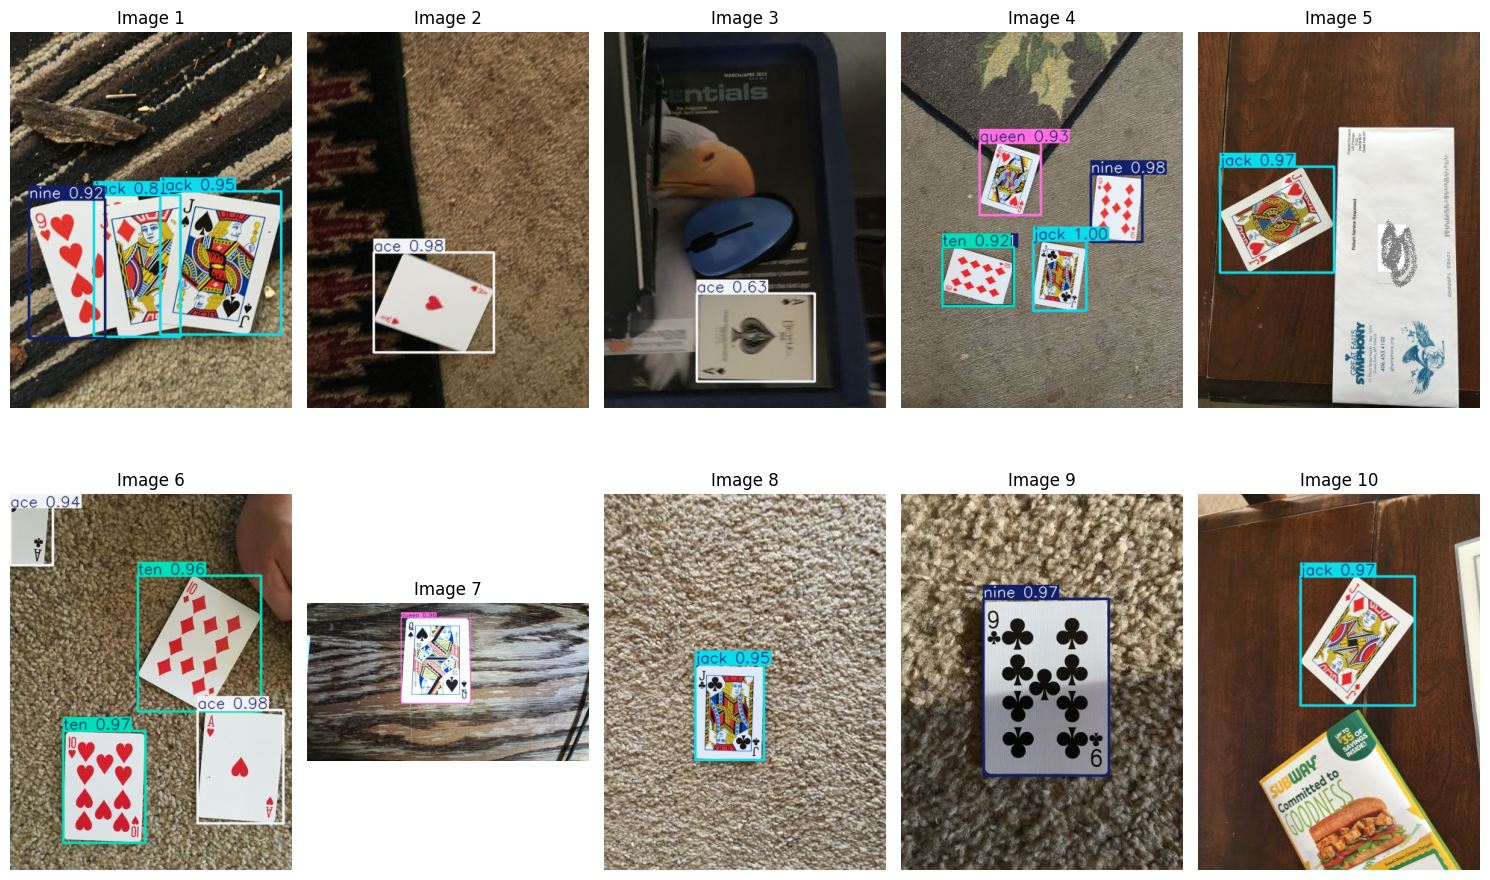

In [ ]:
import os

# Шаг 1: Получение предсказаний
validation_images_dir = "./valid/images"
validation_images = [os.path.join(validation_images_dir, img) for img in os.listdir(validation_images_dir)[10:20]]
results = model.predict(source=validation_images, imgsz=640, conf=0.05)

# Шаг 2: Отображение предсказаний
plt.figure(figsize=(15, 10))
for i, result in enumerate(results[:10]):
    # Получаем изображение с нарисованными bounding box'ами
    img = result.plot()  # Возвращает изображение с bounding box'ами

    # Отображаем изображение
    plt.subplot(2, 5, i + 1)  # 2 строки, 5 столбцов
    plt.imshow(img[:, :, ::-1])  # Переворачиваем каналы BGR -> RGB
    plt.axis("off")
    plt.title(f"Image {i + 1}")

plt.tight_layout()
plt.show()

Формально в логах YOLO метрики тут не очень хорошие из-за кривой разметки на валидации, однако субъективно видно, что модель правильно предсказывает карты, еще и делает это весьма уверенно, даже в случае, когда на первом изображении карты лежат "веером".